In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pandas as pd

# Attempt to load the dataset with a different encoding
df = pd.read_csv(r'C:\Users\FAST\Downloads\trainingprocessednoemoticon.csv', encoding='latin1')

# Inspect column names and first few rows
print(df.columns)
print(df.head())


Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...      

In [3]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Define the feature (X) and target (y) columns
X = df['text']
y = df['target']

# Map target values to a binary classification (0 = negative, 1 = positive)
y = y.map({0: 0, 2: 0, 4: 1})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# Make predictions and evaluate the model
y_pred = nb_model.predict(X_test_vectorized)
print("Naive Bayes Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Naive Bayes Model Performance
Accuracy: 0.76875625
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    159494
           1       0.78      0.76      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [6]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# LSTM modelini oluşturma
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping tanımlama
early_stopping = EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik
    patience=3,          # Doğrulama kaybı iyileşmediğinde kaç epoch bekleyeceği
    restore_best_weights=True  # En iyi ağırlıkları geri yükle
)

# Modeli eğitme
history = model.fit(
    X_train_padded, y_train,
    epochs=40,  # Eğitim süresini uzatabiliriz çünkü early stopping ile erken durdurma yapılacak
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]  # Early stopping'i geri çağırmalara ekleyin
)

# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("LSTM Model Performance")
print("Accuracy:", accuracy)


Epoch 1/40
36000/36000 [==============================] - 547s 15ms/step - loss: 0.4228 - accuracy: 0.8042 - val_loss: 0.4021 - val_accuracy: 0.8157
Epoch 2/40
36000/36000 [==============================] - 532s 15ms/step - loss: 0.3895 - accuracy: 0.8232 - val_loss: 0.3936 - val_accuracy: 0.8206
Epoch 3/40
36000/36000 [==============================] - 537s 15ms/step - loss: 0.3734 - accuracy: 0.8320 - val_loss: 0.3927 - val_accuracy: 0.8216
Epoch 4/40
36000/36000 [==============================] - 530s 15ms/step - loss: 0.3602 - accuracy: 0.8391 - val_loss: 0.3932 - val_accuracy: 0.8216
Epoch 5/40
36000/36000 [==============================] - 1197s 33ms/step - loss: 0.3481 - accuracy: 0.8458 - val_loss: 0.3969 - val_accuracy: 0.8206
Epoch 6/40
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3936 - accuracy: 0.8215
LSTM Model Performance
Accuracy: 0.8214625120162964


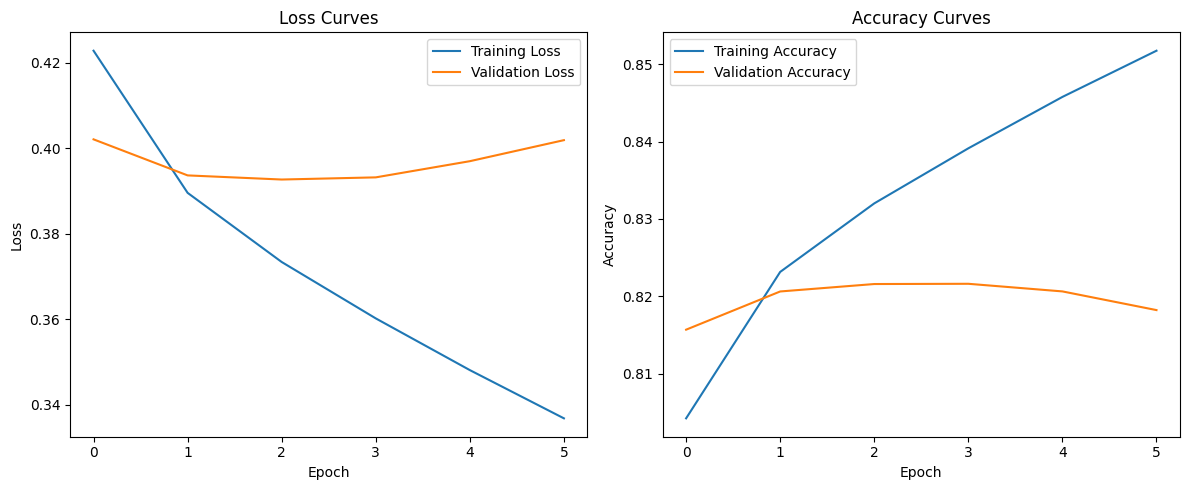

In [10]:
import matplotlib.pyplot as plt

# Plotting training and validation values
plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Saving the model in H5 format
model.save('lstm_model.h5')

# Saving the model in Keras SavedModel format
model.save('lstm_model.keras')


C:\Users\FAST\.conda\envs\jonggg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
